In [1]:
!pip install -q kaggle

In [2]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shubham6000","key":"9689ad05fdf15ebc28822492bf2053a4"}'}

In [4]:
# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.11G/5.11G [04:19<00:00, 24.7MB/s]
100% 5.11G/5.11G [04:19<00:00, 21.1MB/s]


In [6]:
!unzip -q /content/lyft-udacity-challenge.zip -d /content/Dataset

In [7]:
!rm /content/lyft-udacity-challenge.zip

In [8]:
image_path = ['/content/Dataset/'+'data'+i+'/'+'data' +i+'/CameraRGB/' for i in ['A', 'E']]
mask_path  = ['/content/Dataset/'+'data'+i+'/'+'data'+i+'/CameraSeg/' for i in ['A', 'E']]

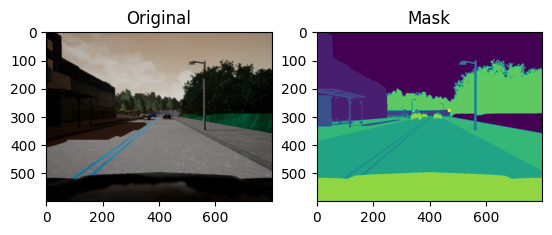

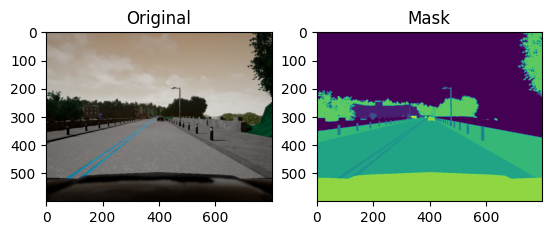

In [9]:

def display_mask():
    
    for i in range(2):
        img_path=image_path[i]
        mk_path=mask_path[i]
        
        img_name=random.choice(os.listdir(img_path))
        
        img=cv2.imread(os.path.join(img_path, img_name))
        #print(img.shape)
        mask=cv2.imread(os.path.join(mk_path, img_name))
        fig, arr=plt.subplots(1,2)
        arr[0].imshow(img)
        arr[0].set_title('Original')
        arr[1].imshow(mask[:,:,2])
        arr[1].set_title('Mask')
        
display_mask()

In [10]:
class SDCDataset(Dataset):
    '''
    For collectively storing the images and the masks
    '''
    def __init__(self, img_dirs, mask_dirs, transform=None):
        self.img_dir=img_dirs
        self.mask_dir=mask_dirs
        self.transform=transform
        self.image_names=[]
        self.mask_names=[]
        if type(self.img_dir)==list:
            for i,j in zip(img_dirs, mask_dirs):
                for n in os.listdir(i):
                    self.image_names.append(os.path.join(i, n))
                    self.mask_names.append(os.path.join(j, n))
        else:
            for n in os.listdir(self.img_dir):
                    self.image_names.append(os.path.join(self.img_dir, n))
                    self.mask_names.append(os.path.join(self.mask_dir, n))

    def __len__(self):
        return len(self.image_names) 
    
    def __getitem__(self, idx):
        img_name=self.image_names[idx]
        image=cv2.imread(img_name)
        mask_name=self.mask_names[idx]
        mask=cv2.imread(mask_name)
        
        sample={'image':image, 'mask':mask}
        
        if self.transform:
            sample['image']=self.transform(sample['image'])
            sample['mask']=self.transform(sample['mask'])
        
        
        return sample

In [13]:
def dataload():
    data_transforms = {
        'Train': transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)), transforms.ToTensor()]), # Resize((256, 256), (256, 256)),
        'Test': transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)), transforms.ToTensor()]), # Resize((256, 256), (256, 256))
    }
    image_datasets={
        'Train':SDCDataset(image_path[:-1], mask_path[:-1], transform=data_transforms['Train']),
        'Test':SDCDataset(image_path[-1], mask_path[-1], transform=data_transforms['Test'])
    }
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                    shuffle=True, num_workers=8)      # num_workers=8
                   for x in ['Train', 'Test']}
    
    return dataloaders, image_datasets

In [14]:
dataloaders, image_datasets = dataload()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Tanh activation after the last convolution layer
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [16]:
model = createDeepLabv3(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:09<00:00, 25.7MB/s]


In [18]:
import csv
import copy
import time
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, roc_auc_score

def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #xm.xla_device() 
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for sample in iter(dataloaders[phase]):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
#                     print(y_pred, y_true)
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    # torch.save(model, os.path.join(bpath, '50epochs_weights.pt'))
    return model

epochs = 6
bpath = "/content/"

# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Specify the evalutation metrics
metrics = {'f1_score': f1_score} #, 'auroc': roc_auc_score}

trained_model=train_model(model, criterion, dataloaders,optimizer, bpath=bpath, metrics=metrics, num_epochs=epochs)
# xmp.spawn(train_model, args=(model, criterion, dataloaders, optimizer, bpath=bpath, metrics=metrics, num_epochs=num_epochs))

torch.save(trained_model, os.path.join(bpath, f'{epochs}epochs_weights.pt'))

Epoch 1/6
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 0.0089


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.0043
{'epoch': 1, 'Train_loss': 0.008905379101634026, 'Test_loss': 0.0043123881332576275, 'Train_f1_score': 0.31667975530312037, 'Test_f1_score': 0.19475238342991277}
Epoch 2/6
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 0.0037


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.0007
{'epoch': 2, 'Train_loss': 0.0036878958344459534, 'Test_loss': 0.0007386053912341595, 'Train_f1_score': 0.150298627598431, 'Test_f1_score': 0.07226071536594478}
Epoch 3/6
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 0.0028


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.0002
{'epoch': 3, 'Train_loss': 0.002836278174072504, 'Test_loss': 0.00019006441289093345, 'Train_f1_score': 0.07825413446534972, 'Test_f1_score': 0.08407799944493904}
Epoch 4/6
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 0.0017


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.0003
{'epoch': 4, 'Train_loss': 0.0017200009897351265, 'Test_loss': 0.00028554839082062244, 'Train_f1_score': 0.046575725804955136, 'Test_f1_score': 0.036088283379715494}
Epoch 5/6
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 0.0009


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.0001
{'epoch': 5, 'Train_loss': 0.0009150038822554052, 'Test_loss': 0.00011077699309680611, 'Train_f1_score': 0.03101643311067743, 'Test_f1_score': 0.028158844288214233}
Epoch 6/6
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 0.0006


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.0003
{'epoch': 6, 'Train_loss': 0.0005879378877580166, 'Test_loss': 0.0002792825107462704, 'Train_f1_score': 0.02252926435365366, 'Test_f1_score': 0.0031553669314555674}
Training complete in 26m 32s
Lowest Loss: 0.000111


In [27]:
# model_path = os.path.join(bpath, f'{epochs}epochs_weights.pth')
model_path = '/content/6epochs_weights.pt'
if torch.cuda.is_available():
    model = torch.load(model_path)
else:
    model = torch.load(model_path, map_location=torch.device('cpu'))
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # xm.xla_device()
# print(device)
# Set the model to evaluate mode
model.eval()

originalImage = cv2.imread('/content/Dataset/dataE/dataE/CameraRGB/02_00_039.png')
img = cv2.resize(originalImage, (256, 256), cv2.INTER_AREA).transpose(2,0,1)
img = img.reshape(1, 3, img.shape[1],img.shape[2])

In [28]:
with torch.no_grad():
#     a = model(torch.from_numpy(img).to(device).type(torch.FloatTensor)/255)
    if torch.cuda.is_available():
        a = model(torch.from_numpy(img).to(device).type(torch.cuda.FloatTensor)/255)
    else:
        a = model(torch.from_numpy(img).to(device).type(torch.FloatTensor)/255)

In [29]:
outImage = a['out'].cpu().detach().numpy()[0]
outImage=outImage.transpose(1,2,0)[:,:,2]

(-0.5, 255.5, 255.5, -0.5)

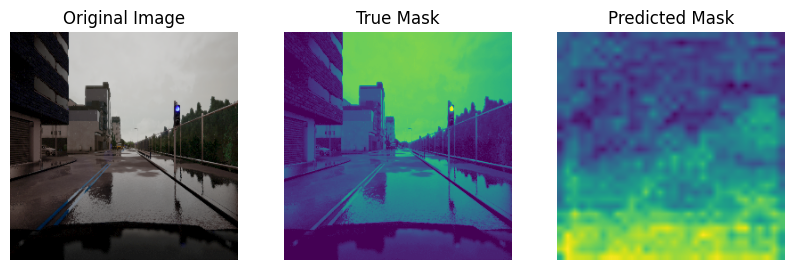

In [30]:
fig, arr=plt.subplots(1,3, figsize=(10,10))

arr[0].imshow(cv2.resize(originalImage, (256, 256)))
arr[0].set_title('Original Image')
arr[0].axis('off')
arr[1].imshow(cv2.resize(cv2.imread('/content/Dataset/dataE/dataE/CameraRGB/02_00_039.png'), (256, 256))[:,:,2])
arr[1].set_title('True Mask')
arr[1].axis('off')
arr[2].imshow(outImage)
arr[2].set_title('Predicted Mask')
arr[2].axis('off')